# IMPORT

In [296]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

# DATA CLEANING

In [297]:
df = pd.read_csv("Train.csv", low_memory=False)
df.info()
def clean_currency(value):
    if pd.isna(value): return np.nan
    try:
        if isinstance(value, str):
            cleaned = ''.join(c for c in value if c.isdigit() or c == '.')
            return float(cleaned) if cleaned else np.nan
        return float(value)
    except:
        return np.nan

currency_cols = ['Client_Income', 'Credit_Amount']
for col in currency_cols:
    df[col] = df[col].astype(str).apply(clean_currency)
    df[col] = pd.to_numeric(df[col], errors='coerce')

numeric_cols = ['Population_Region_Relative', 'Loan_Annuity', 'Age_Days',
                'Employed_Days', 'Registration_Days', 'ID_Days']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73113 entries, 0 to 73112
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          73113 non-null  int64  
 1   Client_Income               70928 non-null  object 
 2   Car_Owned                   70939 non-null  float64
 3   Bike_Owned                  70940 non-null  float64
 4   Active_Loan                 70936 non-null  float64
 5   House_Own                   70943 non-null  float64
 6   Child_Count                 70889 non-null  float64
 7   Credit_Amount               70923 non-null  object 
 8   Loan_Annuity                70256 non-null  object 
 9   Accompany_Client            72065 non-null  object 
 10  Client_Income_Type          70893 non-null  object 
 11  Client_Education            70918 non-null  object 
 12  Client_Marital_Status       71058 non-null  object 
 13  Client_Gender               716

# TRAIN TEST SPLIT

In [298]:

#Dropping unnecessary columns and split
df1 = df.drop(["ID", "Type_Organization"], axis=1)
X = df1.drop("Default", axis=1)
y = df1["Default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# SPLITTING NUMERICAL AND CATEGORICAL DATA

In [299]:

numeric_features = ['Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
                    'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
                    'Population_Region_Relative', 'Age_Days', 'Employed_Days',
                    'Registration_Days', 'ID_Days', 'Client_Family_Members',
                    'Cleint_City_Rating', 'Application_Process_Day',
                    'Application_Process_Hour', 'Score_Source_1', 'Score_Source_2',
                    'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
                    'Credit_Bureau']

categorical_features = ['Accompany_Client', 'Client_Income_Type', 'Client_Education',
                        'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
                        'Client_Housing_Type', 'Client_Occupation']

# INPUTING AND SCALING OF NUMERICAL DATA

In [300]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer()), 
    ('scaler', StandardScaler())
])

# INPUTING AND ENCODING OF CATEGORICAL DATA

In [301]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# COLUMN TRANSFORMER

In [302]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# PIPELINE

In [303]:
pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    #('oversampler', RandomOverSampler(sampling_strategy=0.5, random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    #('classifier',RandomForestClassifier(random_state=42,class_weight="balanced"))
], verbose=True) 

In [304]:
y_test.value_counts()#IMBALANCED DATA

Default
0    13447
1     1176
Name: count, dtype: int64

In [305]:
pipe.fit(X_train, y_train)
print("Pipeline fitted successfully!")


[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.2s
[Pipeline] ...... (step 2 of 3) Processing undersampler, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   1.7s
Pipeline fitted successfully!


In [306]:
from sklearn.metrics import f1_score
y_pred= pipe.predict(X_test)
print("f1_score",f1_score(y_test,y_pred))

f1_score 0.3363021018881368


              precision    recall  f1-score   support

           0       0.95      0.91      0.93     13447
           1       0.29      0.40      0.34      1176

    accuracy                           0.87     14623
   macro avg       0.62      0.66      0.63     14623
weighted avg       0.89      0.87      0.88     14623



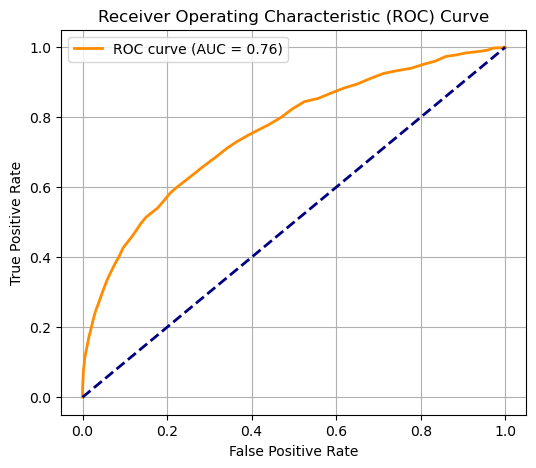

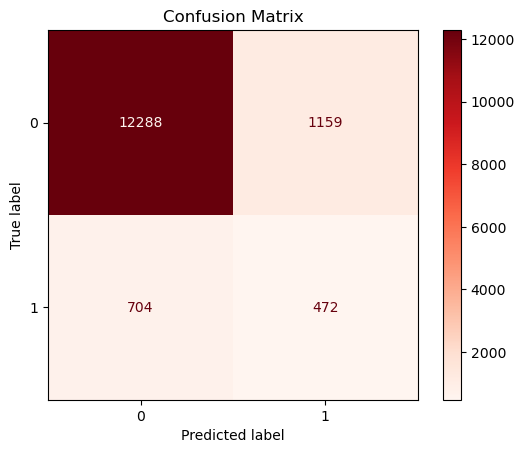

In [307]:
from sklearn.metrics import classification_report,roc_auc_score,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))#recall of 1 was less before undersampling
import matplotlib.pyplot as plt
y_pred_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = pipe.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.show()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot(cmap='Reds')
plt.title("Confusion Matrix")
plt.show()



# RUNNING MODEL ON TEST DATA

In [308]:
df2=pd.read_csv("Test.csv")
test_ids = df2["ID"]
all_numeric_cols = ['Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
                    'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
                    'Population_Region_Relative', 'Age_Days', 'Employed_Days',
                    'Registration_Days', 'ID_Days', 'Client_Family_Members',
                    'Cleint_City_Rating', 'Application_Process_Day',
                    'Application_Process_Hour', 'Score_Source_1', 'Score_Source_2',
                    'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
                    'Credit_Bureau']
for col in all_numeric_cols:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')
X_submit = df2.drop(["ID", "Type_Organization"], axis=1)
y_submit_pred = pipe.predict(X_submit)
submission = pd.DataFrame({
    "ID": test_ids,
    "Default": y_submit_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ Submission file 'submission.csv' created!")


/var/folders/jk/68b4fv7x6wl0bt7x_p91ftf40000gn/T/ipykernel_11452/1090390974.py:1: DtypeWarning: Columns (7,8,17,18,19,20,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df2=pd.read_csv("Test.csv")


✅ Submission file 'submission.csv' created!
